# Group Convolutional Networks

**Author:** Aron Jansen (work in progress)

This notebook goes through the framework of group convolutional networks, which in addition to being invariant (or equivariant) to translations as vanilla CNNs are, are also invariant (equivariant) to a discrete symmetry group.

This notebook is based on the book, lectures and notebooks on the geommetric deep learning by Micheal Bronstein, Joan Bruna, Taco Cohen and Petar Veličković, found [here](https://geometricdeeplearning.com), and of course also on [the original paper](http://proceedings.mlr.press/v48/cohenc16.html) on group convolutions by Taco Cohen and Max Welling.
All credit goes to them, and all mistakes  are my own.

The notebook is meant to be pedagogical and I hope can be useful as an introduction to group convolutions. I recommend to go through it after or in parallel with the sources above. I go into more detail in some areas and less in other. In particular the implementation of a group convolution layer in Keras is explained in detail.

This is a standalone notebook, the actual implementation will differ slightly from the one developed here, but I believe this still gives a clearer introduction.

Any feedback or questions are welcome.

## The group p4m

Before going to group-CNNs, we first explore one particular group as an example: the group of translations, rotations and mirroring of the plane.
This is one of the [wallpaper groups](https://en.wikipedia.org/wiki/Wallpaper_group): a symmetry group containing two translations on a grid, in our case horizontal and vertical translations on a square grid.

What distinguishes a group convolution from a regular one are the symmetries in addition to these translations. These additional symmetries form a group of their own, and is called the point group. 

In the case of our example, the point group is called $D_4$, these are the symmetries of a square: rotations by 90 degrees around the origin, and reflections.

The full wallpaper group with this point group and the two translations on a square grid is called p4m.

Below I will occasionally refer to the point group as the group, because it is only this part of the full group that distinguishes group convolutions from regular convolutions. I hope it is clear from the context.

### Some more context on wallpaper groups (skip on first reading)

There are 17 wallpaper groups in total.  

There are 10 groups on a square or rectangular lattice. Of those 2 have what are called glide reflection symmetries, where one needs to both translate and mirror or rotate at the same time in order for it to be a symmetry. Think of footseps. These have a slighly different structure in that they cannot be decomposed as a point group and the two translations, and we will not consider those either.

The remaining ones that we will consider are these:

\begin{array}{c|c|c|}
\text{wallpaper group}&\text{point group}&\text{order}&\text{symmetries} & \text{lattice} \\
\hline
\text{p1} & C_1 & 1 &\text{nothing} & \text{oblique} \\
\text{p2} & C_2 & 2 & 180^\circ \text{ rotation} & \text{oblique} \\
\text{pm} & D_1 & 2 & \text{single reflection} & \text{rectangular}\\
\text{p2mm} & D_2 & 4 & 180^\circ \text{ rotation, two reflections} & \text{rectangular}\\
\text{c2mm} & D_2 & 4 & 180^\circ \text{ rotation, two reflections (diagonal)} & \text{rhombic} \\
\text{p4} & C_4 & 4 &90^\circ \text{ rotations} & \text{square} \\
\text{p4m} & D_4 & 8 & 90^\circ \text{ rotations, two reflections} & \text{square}
\end{array}

All these point groups are subgroups of the biggest one, $D_4$.
All these wallpaper groups are also subgroups of the biggest one,
except for cmm because its reflections act differently.

Note that the mathematical formalism always assume infinitely extended grids.
An image with a different width and height is still represented on a square grid, as the left-right and up-down neighbors of a pixel are considered to be equally far away. Their different dimensions do however limit the symmetry group to those that are compatible with a rectangular lattice.

On the flip side, a square grid is of course a special case of a rectangular one, so those groups are also compatible with a square grid.


## Derivation of the group structure

A group element takes the form $({\bf t}, r, f)$, which acts on the plane as:
1. $f \in \{0, 1\}$ (True or False) flips along the horizontal direction
2. $r \in \{0, 1, 2, 3\}$ rotates by $r \frac{\pi}{2}$, counterclockwise around the origin
3. ${\bf t} = (t_x, t_y)$ translates

A generic element takes all three actions in the order given.

(Why only one flip when the table above said there are two? Because the vertical one can be decomposed as a horizontal flip and a 180 degree rotation, see the images later.)

Consider the pure flips, rotations and translations, and the identity $e$. We write them as follows, and also show their action on the plane:
- $F = (0, 0, 1)$,   
    - $F\cdot(x, y) = (-x, y)$
- $R = (0, 1, 0)$
    - $R\cdot(x, y) = (-y, x)$
- ${\bf t} = ({\bf t}, 0, 0)$
    - ${\bf t}\cdot(x, y) = (x + t_x, y + t_y)$
- $e = (0, 0, 0)$
    -  $e \cdot (x, y) = (x, y)$

(Where for later clarity we write the action of a group element $g$ on a point $(x, y)$ as $g \cdot (x, y)$.)

Then we can write any element as:
$({\bf t}, r, f) = {\bf t} \odot R^r \odot F^f$, where $\odot$ denotes group composition.

Each component creates its own subgroup:
- $F \odot F = e$, flips are a 2 dimensional subgroup
- $R^r \odot R^s = R^{r + s \mod 4}$, rotations give the 4-dimensional cyclic group
- ${\bf t} \odot {\bf r} = \bf{t + r}$, translations trivially form the group of translations

Now to find the group composition, we need to untangle the following expression,
$a \odot b = {\bf t}_a \odot R^{r_a} \odot F^{f_a} \odot {\bf t}_b \odot R^{r_b} \odot F^{f_b} = {\bf t}_c \odot R^{r_c} \odot F^{f_c} = c$.

So we want to pull first the $F^{f_a}$ past the ${\bf t}_b \odot R^{r_b}$ to find $f_c$, and then pull $R^{r_b}$ past ${\bf t}_b$ to find $r_c$, which will then also allow us to find ${\bf t}_c$.
These do not commute, but by looking at the action on the plane we can see how we can still swap elements:

- $\begin{align}
(F \odot {\bf t})\cdot(x, y) &= F\cdot(x + t_x, y + t_y) = (-x - t_x, y + t_y)\\
&= (F\cdot{\bf t})\cdot(-x, y) = ((F\cdot{\bf t}) \odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(F \odot R)\cdot(x, y) &= F\cdot(-y, x) = (y, x) \\
&= R^{-1}\cdot(-x, y) = (R^{-1}\odot F)\cdot(x, y)
\end{align}$
- $\begin{align}
(R \odot {\bf t})\cdot(x, y) &= R\cdot(x + t_x, y + t_y) = (- y - t_y, x + t_x)\\ &= (R\cdot{\bf t})\cdot (-y, x) = ((R\cdot {\bf t}) \odot R)\cdot(x, y)
\end{align}$

where in the second and last lines we let $F$ and $R$ act on ${\bf t}$ as a point in the plane.

Since these three identities hold for all points $(x, y)$, they imply:
- $F \odot {\bf t} = (F{\bf t}) \odot F$
- $F \odot R = R^{-1} \odot F$
- $R \odot {\bf t} = (R{\bf t}) \odot R$

With these identities, we can write the product of two generic group elements, $a \odot b$, and bring all the flips to the far right, the rotations to the middle and the translations to the left. Doing this and reading off the resulting components gives the following rules for group composition:
- $f_c = f_a + f_b$
- $r_c = r_a + (1 - 2 f_a) r_b$
- ${\bf t}_c = {\bf t}_a + R^{r_a} F^{f_a} {\bf t}_b$

And from this we can find the inverse element:
- $f^{-1} = f$
- $r^{-1} = - (1 - 2 f) r$
- ${\bf t}^{-1} = - F^f R^{-r} {\bf t}$

The class below implements this group. It uses multiplication as group composition, and `~` can be used as the inverse.

In [1]:
class P4M:
  """
  First flip horizontally, then rotate counterclockwise around origin, then translate.
  """
  def __init__(self, rotation: int=0, flip: int=0, translation: tuple=(0, 0)):
    assert type(translation) == tuple
    self.rotation = rotation % 4
    self.flip = flip % 2
    self.translation = translation
  
  def __mul__(a, b):
    """Group composition a o b."""
    flip = (a.flip + b.flip) % 2
    rotation = (a.rotation + (1 - 2 * a.flip) * b.rotation) % 4
    a_x, a_y = a.translation
    b_x, b_y = b.translation
    if a.flip:
      b_x = -b_x
    for _ in range(a.rotation):
      b_x, b_y = P4M.rotate(b_x, b_y)
    translation = (a_x + b_x, a_y + b_y)

    return P4M(rotation=rotation, flip=flip, translation=translation)

  def __invert__(self):
    """Group inverse."""
    flip_inv = self.flip
    rotation_inv = (-(1 - 2 * self.flip) * self.rotation) % 4
    x_inv, y_inv = self.translation
    for _ in range(self.rotation):
      x_inv, y_inv = P4M.inv_rotate(x_inv, y_inv)
    if self.flip:
      x_inv = -x_inv

    translation_inv = x_inv, y_inv
    return P4M(rotation=rotation_inv, flip=flip_inv, translation=translation_inv)

  def __call__(self, point):
    """Action on plane."""
    result_x, result_y = point
    if self.flip:
      result_x = -result_x
    for _ in range(self.rotation):
      result_x, result_y = P4M.rotate(result_x, result_y)
    t_x, t_y = self.translation
    return result_x + t_x, result_y + t_y

  def __repr__(self):
    return f'({self.translation}, {self.rotation}, {self.flip})'

  def __str__(self):
    if self.is_identity():
      return 'e'
    string = ''
    if self.translation != (0, 0):
      string += f'{self.translation}'
    if self.rotation > 0:
      string += f'R^{self.rotation}'
    if self.flip:
      string += 'F'

    return string

  def is_identity(self):
    return self.flip == 0 and self.rotation == 0 and self.translation == (0, 0)

  def __eq__(self, other):
    return self.flip == other.flip and self.rotation == other.rotation and self.translation == other.translation
  
  @staticmethod
  def rotate(x, y):
    return -y, x

  @staticmethod
  def inv_rotate(x, y):
    return y, -x

  def __hash__(self):
    return hash((self.flip, self.rotation, self.translation))

## Check the identities

Now we can check the identities we used to derive the group composition. We define `F` and `R` as above to be the flip and single rotation.

The translation is a bit more involved for two reasons. First, we didn't have a single representative of this subgroup. It can of course be built from two generators (the unit translation in the x direction and the unit translation in the y direction), but this only complicates things, so we just pick a generic point.

The more interesting complication is that we can identify a pure translation in the group with a point on the plane, on which the group acts. It makes the code a bit more cumbersome than for the identity that doesn't involve a translation, but that is good in that it stresses that these are two different objects. In most cases such a mapping cannot be done.

In [2]:
F = P4M(flip=1)
R = P4M(rotation=1)
T_point = (4, 2)
T = P4M(translation=T_point)

print(F * T == P4M(translation=F(T_point)) * F)
print(F * R == ~R * F)
print(R * T == P4M(translation=R(T_point)) * R)

True
True
True


## Checking the full multiplication table

We can also easily construct the multiplication table of the group, or really the table of group compositions, for the point group.

First we make a list of the elements in the group:

In [3]:
unique_elements = []
for flip in range(2):
  for rotation in range(4):
    unique_elements.append(P4M(flip=flip, rotation=rotation))
  
print(' '.join([str(g) for g in unique_elements]))

e R^1 R^2 R^3 F R^1F R^2F R^3F


And then we can just multiply them to find the group compositions:

In [4]:
products = [[a * b for b in unique_elements] for a in unique_elements]

Which we can display nicely as below. The rows and columns are group elements $g_r$ and $g_c$, and the entries in the table denote the result of composing them as $g_{rc} = g_r \odot g_c$.

This can be compared for instance to [this table](https://proofwiki.org/wiki/Dihedral_Group_D4/Cayley_Table). Note that apart from remaning $R$ to $a$ and $F$ to $b$, these tables are not the same. The reason is that we have chosen a different basis: we first apply flips and then rotations, while in the linked table flips are applied after rotations. It is left as an exercise to the reader to show that the two tables are in fact consistent.

In [5]:
from tabulate import tabulate

print("Group composition: row o column")
print(tabulate(products, headers=unique_elements, showindex=unique_elements, tablefmt='fancy_grid'))

Group composition: row o column
╒══════╤══════╤═══════╤═══════╤═══════╤══════╤════════╤════════╤════════╕
│      │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
╞══════╪══════╪═══════╪═══════╪═══════╪══════╪════════╪════════╪════════╡
│ e    │ e    │ R^1   │ R^2   │ R^3   │ F    │ R^1F   │ R^2F   │ R^3F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1  │ R^1  │ R^2   │ R^3   │ e     │ R^1F │ R^2F   │ R^3F   │ F      │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^2  │ R^2  │ R^3   │ e     │ R^1   │ R^2F │ R^3F   │ F      │ R^1F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^3  │ R^3  │ e     │ R^1   │ R^2   │ R^3F │ F      │ R^1F   │ R^2F   │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ F    │ F    │ R^3F  │ R^2F  │ R^1F  │ e    │ R^3    │ R^2    │ R^1    │
├──────┼──────┼───────┼───────┼───────┼──────┼────────┼────────┼────────┤
│ R^1F

### Group composition as permutations

By enumerating the group elements in the order above, we can represent the group composition as a set of permutations. 

The $r$-th group element $g_r$ defines a permutation of the whole group, where
$g_r \odot g_c = g_k$, with $k = permutations[r][c]$.

In [6]:
elem_numbers = {g: i for i, g in enumerate(unique_elements)}
permutations = [[elem_numbers[g] for g in row] for row in products]
permutations

[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 0, 5, 6, 7, 4],
 [2, 3, 0, 1, 6, 7, 4, 5],
 [3, 0, 1, 2, 7, 4, 5, 6],
 [4, 7, 6, 5, 0, 3, 2, 1],
 [5, 4, 7, 6, 1, 0, 3, 2],
 [6, 5, 4, 7, 2, 1, 0, 3],
 [7, 6, 5, 4, 3, 2, 1, 0]]

### Checking inverses

In [7]:
print(' '.join([str(g * ~g) for g in unique_elements]))
print(' '.join([str(~g * g) for g in unique_elements]))

e e e e e e e e
e e e e e e e e


## Group action

Even though we introduced the group by starting from the symmetries of the plane, mathematically a group is independent of its actions on any other objects. It is defined purely by the group composition.

In particular the same group can act on many different spaces, and even on a fixed space and for a fixed group, different actions can be defined.

The defining property of a group action is that if we do multiple transformations, it doesn't matter how we do it.
We either compose the two group elements, and let the resulting group element act on the space. Alternatively and equivalently, we can first act with one group element, and then with the other:

$(g \odot h) \cdot x = g \cdot (h \cdot x)$

In fact this property is what we implicitly used above to go from the action on the plane that we wanted to the underlying group structure. 

#### Action on grid $\Omega$

Before verifying whether this property holds, we need to define the action on a grid. Luckily the rotations and mirrorings map to simple tensorflow operations.
With the three elementary transformations:

- horizontal flip
- vertical flip
- transposition

we can create 2^3 = 8 different transformations, which map exactly to the previously discussed action on the plane.

In [8]:
import tensorflow as tf

def flip_grid(x, height_axis=-3, width_axis=-2):
  return tf.reverse(x, axis=[width_axis])

def rotate_grid(x, height_axis=-3, width_axis=-2):
  axes = list(range(len(x.shape)))
  axes[height_axis], axes[width_axis] = axes[width_axis], axes[height_axis]
  return tf.reverse(tf.transpose(x, perm=axes), axis=[height_axis])

def act_on_grid(x, g, height_axis=-3, width_axis=-2):
  if g.flip:
    x = flip_grid(x, height_axis=height_axis, width_axis=width_axis)
  for _ in range(g.rotation):
    x = rotate_grid(x, height_axis=height_axis, width_axis=width_axis)
  return x

To demonstrate what this action does to the grid, we need some more structure, as by construction the actions all leave the grid itself invariant.

We can take an image on the grid, which is nothing but an assignment of pixel values to each point in the grid. At this point we use this merely to illustrate that the action above does what we want it to. Later we will see that the desired action of the group on _signals on the grid_ is subtly different from the action on the grid itself. 

It is also for later convenience that we have set the default height and width axes to be -3 and -2, as the last index will be reserved for values on the grid.

Also note that for rotation to be a symmetry the grid clearly needs to be square. For generality though we will keep distinguishing the height from the width. (Restricting the group to horizontal and vertical flips will still give a nontrivial symmetry if the grid is not square.)

#### Illustrate action on MNIST

In [9]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

input_shape = (28, 28, 1)
num_classes = 10

from matplotlib import pyplot as plt
import numpy as np

image = np.reshape(x_train[2].numpy(), (28, 28, 1))

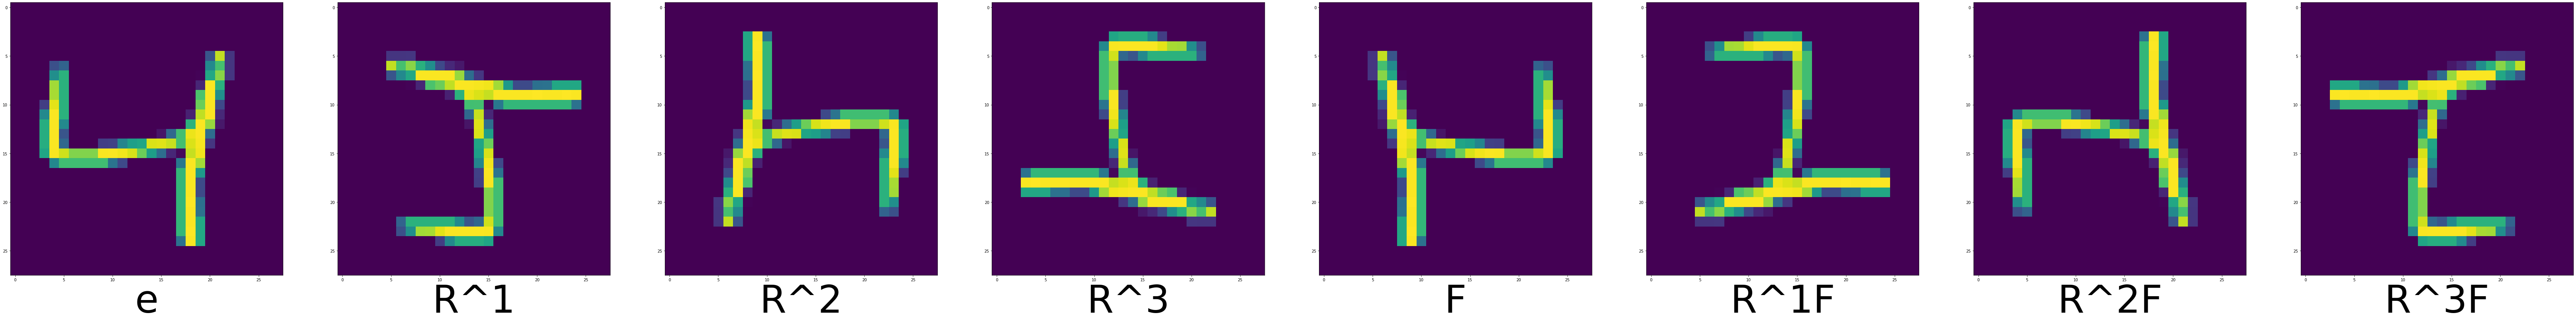

In [10]:
transformed_images = [act_on_grid(image, g) for g in unique_elements]

fig, axes = plt.subplots(1, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
for i in range(8):
  axes[i].imshow(transformed_images[i][:, :, 0])
  axes[i].set_xlabel(str(unique_elements[i]), fontsize=100)
fig.show()

#### Checking compatibility of composition and action

Now that we have defined the action on the grid, we can check if this is compatible with group composition. We might as well test it on the digit above.

We compute the quantity $(g_r \odot g_c)(x) - g_r \cdot (g_c \cdot x)$ and indeed find that it vanishes for all combinations of group elements.

In [11]:
differences = [[0 for _ in unique_elements] for _ in unique_elements]
for r in range(8):
  for c in range(8):
    g_r = unique_elements[r]
    g_c = unique_elements[c]
    g_rc = unique_elements[permutations[r][c]]

    gc_x = act_on_grid(image, g_c)
    gr_gc_x = act_on_grid(gc_x, g_r)
    grc_x = act_on_grid(image, g_rc)

    differences[r][c] = tf.reduce_max(tf.abs(grc_x - gr_gc_x)).numpy()

for row in differences:
  print(row)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Group action on signals

So far we have interpreted the group as acting on the grid. We have also in a way looked at the action of the group on itself: this is just another way of looking at the group composition rules we derived.

A crucial property of both of these actions is that it doesn't matter where we put the brackets. In fact this must be true of any action for it to make sense.

### Signals

Ultimately though we are not interested in just the grid or even the group by itself. We want to classify images or other machine learning tasks.
So rather than a grid by itself, we want to analyse data on a grid, in particular pixel values on each grid point.

A formal way of looking at an image is as a signal on the grid: a function from the grid to the real numbers, or to 3 real numbers for color images. We denote the set of all such functions as $\mathcal{X}(\Omega, \mathcal{C}) \equiv \{f: \Omega \rightarrow \mathcal{C} \}$, where $\Omega$ is the grid itself, and $\mathcal{C}$ will typically be $\mathbb{R}^n$ for some number of features $n$.

The data itself of a color image will still be a tensor of shape (height, width, 3), whose entry i,j gives the RGB values at the i,j-th gridpoint.
We are free to think of the first two axes to be inputs to a function, and the last axis to be the corresponding output. The data defines a function by giving its value on all of the possible inputs, i.e. all grid points.





#### Group Actions

From a group G acting on a domain $\Omega$, we can immediately construct an action of the group on signals $\mathcal{X}(\Omega, \mathcal{C})$ on this domain: for $g \in G$, $y \in \mathcal{X}(\Omega, \mathcal{C})$ and $x \in \Omega$:

$(g \otimes y)(x) = y(g^{-1} \cdot x)$.

The inverse here is crucial to make this a proper group action. This can be seen by looking at another group element $h \in G$ and verifying that this makes the action compatible with group composition:

$(h \otimes (g \otimes y))(x)  = (g \otimes y)(h^{-1} \cdot x) = y(g^{-1} \cdot (h^{-1} \cdot x)) = y((g^{-1} \odot h^{-1}) \cdot x) = y((h \odot g)^{-1} \cdot x) = ((h \odot g) \otimes y)(x)$

where we used that $(h \odot g)^{-1} = g^{-1} \odot h^{-1}$.

So the action on the image we did before wasn't a proper action, as we didn't use the inverse.

We have just created a representation of the group on signals on the domain $\Omega$ purely through the group action directly on $\Omega$ that we already had. But we also already had another group action: the one on the group itself by composition. Using this we can repeat the trick to create a group action on signals on the group itself.

To summarize, these are the relevant group actions.

\begin{array}{c|cccc}
\text{space}&\text{action}&\text{computed as} & \text{meaning} & \text{shape}\\
\hline
\Omega& g \cdot p & - & \text{pixel indices} & (h, w)\\
G & g \odot h & - & \text{transformations} & (h, w, n_g)\\
\mathcal{X}(\Omega) & (g \otimes x)(p) & x(g^{-1}\cdot p) & \text{image} & ( h, w, n_c)\\
\mathcal{X}(G) & (g \circ y)(h) & y(g^{-1} \odot h) & \text{hidden activations} & (h, w, n_g, n_c)
\end{array}

In the two signal spaces, note that the group action does not depend on the image of the signals, only their domain. That is why the image is not indicated, although in both cases it will turn out to be the group itself for group convolutions.

We have reduced the 4 actions effectively to two: the action on the domain and the composition of group elements.
As the group in question is a combination of translations and a point group, we can decompose this further. In fact, the group composition acts on the translational part exactly as it does on the domain itself. We can easily check this with an example:

In [12]:
g = T * F * R
print('g: ', g)

h = P4M(translation=(3, 1)) * F
print('h: ', h)
x = (3, 1)
print('x: ', x)
print('gx: ', g(x))
print('gh: ', g * h)

g:  (4, 2)R^3F
h:  (3, 1)F
x:  (3, 1)
gx:  (5, 5)
gh:  (5, 5)R^3


So the action on the group can be decomposed as first acting on the translation group element as if it was in the domain itself, and then acting on the point group elements. This last part by definition is nothing but a permutation, and for a given group element the corresponding permutation is precisely the one indicated in the multiplication table above.

So to act with a particular group element $g$ on a signal $\mathcal{X}(G)$ of shape $(n_h, n_g, h, w)$:

1. Apply the flip and rotation on the $(h, w)$ dimensions
2. Apply the translation on the $(h, w)$ dimensions
3. Permute the $n_g$ dimension according to the row of $g$ in the multiplication table.

And acting on signals on the domain $\mathcal{X}(\Omega)$ is the same, simply omit the last step.

Generalizing this to any group that combines translations with a point group, the two pieces of information we need for every point group element are these:
1. an action on $\mathcal{X}(\Omega, \mathcal{C})$


In [13]:
@tf.function
def P4M_action(kernel, new_group_axis=0, height_axis=0, width_axis=1):
  return tf.concat([tf.expand_dims(act_on_grid(kernel, g, height_axis=height_axis, width_axis=width_axis), 
                                   axis=new_group_axis) for g in unique_elements], axis=new_group_axis)

2. A permutation giving the point-group part of the group composition

Here we have to be careful. The action above in an action on signals on the domain. So the result of applying this action on an image $x \in \mathcal{X}(\Omega, \mathcal{C})$ is a tensor of the form

$(g, g \otimes x(u)) = (g, x(g^{-1} \cdot u))$

because that is how the group acts on a signal on the domain.

Now we also want to implement the action on a signal on the group $y \in \mathcal{X}(G, \mathcal{C})$. If we split the group element into a translational part $u$ (equivalently a point in the grid), and a non-translational part $h$, then another group element $g$ should act on this signal to produce a tensor of the form:

$(g, g \odot y(h, u)) = (g, y(g^{-1} \otimes h, g^{-1} \cdot u))$

The action on $u$ is already taken care of, we can just apply the action above first. But for the action on the non-translational part of the group, we need to act on it with the inverse group element $g^{-1}$.

So we actually need a different permutation matrix, because we had `permutations`[r][c]$ = g_r \otimes g_c$, but what we need to use is `permutations_inv`[r][c]$ = g_r^{-1} \otimes g_c$. Fortunately we can create this jsut as easily:

In [14]:
products_inv = [[(~a) * b for b in unique_elements] for a in unique_elements]
permutations_inv = [[elem_numbers[g] for g in row] for row in products_inv]
P4M_permutation = tf.constant(permutations_inv)

In [15]:
P4M_permutation

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[0, 1, 2, 3, 4, 5, 6, 7],
       [3, 0, 1, 2, 7, 4, 5, 6],
       [2, 3, 0, 1, 6, 7, 4, 5],
       [1, 2, 3, 0, 5, 6, 7, 4],
       [4, 7, 6, 5, 0, 3, 2, 1],
       [5, 4, 7, 6, 1, 0, 3, 2],
       [6, 5, 4, 7, 2, 1, 0, 3],
       [7, 6, 5, 4, 3, 2, 1, 0]], dtype=int32)>

Finally the translations are of course already implemented in vanilla CNNs. We will modify Keras's Conv2D layer to add the two pieces of information above.

# Geometric DL Blueprint

The philosophy of geometric deep learning is to maximally use the symmetries of the domain by stacking layers that are equivariant, potentially ending in an invariant layer if the network's output should be invariant (as is the case in image classification, but not for instance in image segmentation).

In general a function $f: X \rightarrow Y$ is equivariant to some symmetry group $G$ of its domain $X$ if for all inputs $x \in X$ and all group elements $g \in G$:

__equivariance:__

$f(g \cdot x) = (g \otimes f)(x)$

and invariance is the special case where the action on the function is trivial:

__invariance:__

$f(g \cdot x) = f(x)$

These properties are what we would like layers of the neural network to have. Such layers send for instance an image to a smaller "image" of features. So a layer is a map from signals on the domain to other signals on a domain (the same or another). This is the third layer of abstraction, it is useful to list these to avoid confusion:
1. The domain $\Omega$: a grid of points without values
2. Signals $\mathcal{X}(\Omega, \mathcal{C})$: images on the grid
3. maps between signals $\{\mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(\Omega^\prime, \mathbb{R})\}$: neural network layers

The most interesting equivariant layer is the group-convolution layer, which we discuss next.

## Equivariant Layer: Group convolution

### Normal convolution

Before diving into group convolution it's useful to rephrase regular convolution in this language. There too a convolution layer is a map between signals, say from pixel values on a grid, to hidden feature vectors on the same grid (or possibly a smaller grid if we don't use padding or use a stride). Both grids have translation invariance.

For an image, or signal on the grid $x \in \mathcal{X}(\Omega, \mathcal{C})$, and a kernel, which is also a signal on the grid, $\psi \in \mathcal{X}(\Omega, \mathcal{C})$, we denote the convolution by the map $C_\psi: \mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(\Omega^\prime, \mathcal{C}^\prime)$, defined as

$C_\psi(x)(t) \equiv (\psi \star x)(t) = \sum_{u \in \Omega} \langle \psi(u - t), x(u) \rangle_\mathcal{C}$

here $\langle \cdot, \cdot \rangle_\mathcal{C}$ is just the inner product: $x(u)$ is a feature vector with m components, then a single kernel is too, and convolution sums their inner products to produce a single number at each grid point. In practice of course we use multiple kernels, to go from an $m$-dimensional feature vector to a, possibly larger, $m^\prime$-dimensional feature vector.

The argument of the filter is translated by $-t$. We can rephrase this by thinking of $t$ as an element of the translation group, rather than a point on the grid. We had already seen that for this particular case the group and the domain happen to coincide. So $u - t = t^{-1} \cdot u$, where on the left hand side $t$ is a point on the grid and on the right hand side it is an element of the translation group. Using the action on signals, we can take it outside of the argument: $\psi(t^{-1} \cdot u) = (t \otimes \psi)(u)$. So we can write the convolution as:

$(\psi \star x)(t) = \sum_{u \in \Omega} \langle(t \otimes \psi)(u), x(u)\rangle_\mathcal{C}$

where importantly we now interpret the argument $t$ of the convolved signal as a group element.

Note that locality, another feature of convolutions as they are usually done, which is essential to its success, is not apparent here. In fact it is not strictly necessary, but can be easily imposed just by setting the kernel to zero everywhere but on a small square. 

What is apparent is the other feature crucial to the success of convolutions: weight sharing. The output at any element of the translation group is computed using the same kernel. This is what makes it equivariant to translations, but rather than show that now we first generlaize this to group convolutions, and then show it for the more general case.

### Lifting convolution

Having framed the normal convolution in this way, the generalization to group convolutions is almost immediate. A  _group convolution_ is a map:
$C_\psi^G: \mathcal{X}(\Omega, \mathcal{C}) \rightarrow \mathcal{X}(G, \mathbb{R})$ defined as:

$C_\psi^G(x)(g) \equiv (\psi \star x)(g) = \sum_{p\in\Omega} \langle(g \otimes \psi)(p), x(p)\rangle_\mathcal{C}$.

In particular this is also called a _lifting convolution_, because it maps signals on the domain to signals on the group.

This reduces to the normal convolution when the group $G$ is only the translation group, but here we will think of it as including more symmetries.

To see that this is $G-$equivariant, transform either the output or the input with $h \in G$ using the previously defined group actions:
- $(h \circ C_\psi^G(x))(g) = C_\psi^G(x)(h^{-1} \odot g) = \sum_{p\in\Omega} \langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C}$
- $C_\psi^G(h \otimes x)(g) = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

So if we can show that

$\sum_{p\in\Omega}\langle [(h^{-1} \odot g) \otimes \psi](p), x(p) \rangle_\mathcal{C} = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

then $C_\psi^G$ is $G-$equivariant. 
We can make the left hand side look more like the right hand side by rewriting it as:
- $[(h^{-1} \odot g) \otimes \psi](p) = [h^{-1} \otimes (g \otimes \psi)](p) = (g \otimes \psi)(h \cdot p)$, and
- $x(p) = (h \otimes x)(h \cdot p)$

so that we get

$\sum_{p\in\Omega}\langle (g \otimes \psi)(h \cdot p), (h \otimes x)(h \cdot p) \rangle_\mathcal{C} = \sum_{p\in\Omega} \langle (g \otimes \psi)(p), (h \otimes x)(p)\rangle_\mathcal{C}$

where now the only difference is that on the left we have $h \cdot p$ as arguments and on the right we have only $p$.
So without the sum, the two sides are _not_ equal, but as long as both sides still sum over the same set, they are equal. So what we need is that $h \cdot \Omega = \Omega$, for any $h \in G$. 

This is true because any action of a group $G$ on a domain $\Omega$ defines a bijection from $\Omega$ to itself, i.e. the sets are indeed the same.
This can be seen from the existance of the inverse $h^{-1} \in G$: if $h\cdot p = h\cdot q$, then by applying $h^{-1}$ to both sides we get $p = q$.

### Group convolution

We've considered convolution of signals on $\Omega$, but they get mapped to signals on the group. So if we want to have more than a single convolution layer, we'll need to define convolution of signals on the group as well.

Fortunately, the definition is almost identical, and signals on the group remain signals on the group. For completeness, a group convolution is a map $C_\psi^G: \mathcal{X}(G,\mathcal{C})\rightarrow \mathcal{X}(G, \mathbb{R})$ defined as

$C_\psi^G(y)(g) \equiv (\psi \star y)(g) = \sum_{h\in G} \langle(g \circ \psi)(h), y(h)\rangle_\mathcal{C}$,

where now $y, \psi \in \mathcal{X}(G, \mathcal{C})$.


The proof of equivariance goes through in the same way, as also $h\odot G = G$, since for all $g$, $h^{-1} \odot g \in G$ and so $g \in h \odot G$.

Note that nowhere in this discussion we have used that the group contains translations, this is not necessary in order to define a group convolution.

### Practical implementation

As already noted, an efficient implementation of regular convolutions is already available in many frameworks, most importantly for us in Keras's `Conv2D` layer. We will subclass this layer to make an efficient implementation of group convolutions.

We'll make sure the layer has input and output shapes that are natural, meaning that signals on the group will have an additional axis. This won't work with the `Conv2D` layer though, so internally we'll need to merge this axis with the channel axis.

So at a high level the name of the game is to first reshape the kernels so we can apply the group transformation, reshape them and the input again so we can apply the convolution, and then reshape the result to get it into a natural form.

Rather than showing the whole class here, we'll discuss the main methods here and then import it.

_From here on, when I say group I mean only the point group, here the rotations and reflections, as the translational part is already taken care of._

#### Initialization

As mentioned, the only dependence on the group is through its composition, represented by a tensor of permutations, and its action. To decouple the details of the group from the implementation of the group convolution, and make it able to generalize to any group, we'll pass these as arguments. So the init method will look like this:

In [16]:
def __init__(self, group_action, group_composition: tf.Tensor, **kwargs):
  self.group_action = group_action
  self.group_composition = group_composition
  self.group_order = group_composition.shape[0]
  self.group_valued_input = None # set during build

  super().__init__(**kwargs)

Where we extract the group order, i.e. the number of elements, from the group composition. Note that group order here refers only to the non-translational part of the group, as that part is already handled by the standard convolution.

We also include a boolean `group_valued_input` indicating whether the layer acts on signals on the group. 


#### build

The build method does two things. One is to find out whether the layer is being applied to group valued input and set the flag. 

If the input is a signal on the domain rather than the group, it is already of the shape expected by the `Conv2D` layer and we're done. 

If the input _is_ a signal on the group, it will have, by our conventions, a shape `(batch, height, width, group_order, channels_in)`, whereas `Conv2D` expects a shape `(batch, height, width, channels_in)`, so we need to get rid of the extra group axis somehow.

What we can do is to merge it with the `channels_in` axis, so instead of having a vector of size `channels_in` for each group element, we'll have a vector of size `in_channels * group_order` on each point in the grid (i.e. each translational group element). 

Then we call `Conv2D`'s build method with this input shape. This will create the kernel, which will be of shape `(height, width, group_order * channels_in, channels_out)`, which we can reshape into `(height, width, group_order, channels_in, channels_out)`, which are `channels_out` different signals on the group, with values of the same dimension (`channels_in`) as the input, as required.

The reason this works is that now both the input and the kernel have feature vectors of size `group_order * channels_in`, and in the convolution their inner product will be taken. But an inner product of these large feature vectors is of course the same as taking the inner product of all `group_order` vectors of size `in_channels` and then adding those together.

In [17]:
def build(self, input_shape):
    self.group_valued_input = len(input_shape) == 5  # this includes the batch dimension
    if self.group_valued_input:
        (batch, height, width, group_order, channels) = input_shape
        assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
        input_shape = (batch, height, width, channels * group_order)

    super().build(input_shape)

    if self.group_valued_input:
        self.input_spec.axes = {self._get_channel_axis(): channels}

The last two lines here are to make it accept input in which the group axis is factored out again.

#### call

The call method is very simple, we can use `Conv2D`'s call method on a transformed input, using a transformed kernel and bias. 
Then we reshape the output to make the group axis explicit again.

(The only difference between `original_call` and the parent class `Conv2D`'s call method is that we've replaced calls to `self.kernel` and `self.bias` with arguments, to be able to pass in the transformed kernel and bias.)

In [18]:
def call(self, inputs):
    outputs = self._conv2d_call(
        self._merge_group_axis(inputs),
        self._group_transform_kernel(),
        self._repeat_bias()
    )
    return self._restore_group_axis(outputs)


The essence of course is in these transformations, so let's discuss these now.

#### merge/restore group axis

Merge group axis does what we promised to do in the build method: merge the group axis with the channel axis.

We need to take care to do this consistently, the same for the input and the filter, and to undo it in the same way later. We always merge with the group axis on the left of the channel axis.

The batch line is necessary to make this work for a symbolic tensor that doesn't have the batch size specified.

In [19]:
def _merge_group_axis(self, inputs):
  if not self.group_valued_input:
      return inputs

  batch, height, width, group_order, channels = inputs.shape
  batch = -1 if batch is None else batch
  return tf.reshape(inputs, (batch, height, width, group_order * channels))

The `restore_group_axis` method does the exact opposite of this, so we will not repeat it here. The only difference is that this method does not need to check `group_valued_input`, as the output of a group convolution is always a signal on the group.

#### group transform

Recall that for a group convolution we need to:
1. transform the kernel with the group
2. translate the kernel
3. take the inner product of the filter and the input
4. sum this over the input domain (or the group if it was a signal on the group)

All but step 1 are also necessary for regular convolutions and thus implemented in `Conv2D`, so we only need to do step 1, and then bring the kernel in the right shape.

The code looks like this:
 

In [20]:
def _group_transform_kernel(self):
    transformed_kernel = self.group_action(self.kernel)
    if self.group_valued_input:
        transformed_kernel = self._discrete_group_transform(transformed_kernel)

    transformed_kernel = self._merge_group_channels_out(transformed_kernel)
    return transformed_kernel

The action of a group element on the kernel consists of two parts: 
1. the action on the grid (or the translation group)

and if acting on a signal on the group:
2. the action on the group 

The first is what we assume is given as the group action, so we just apply that.
This results in a transformed kernel of shape `(height, width, group_order, channels_in, channels_out)`, which is the concatenation along the third axis of the result of all group actions.

Then if it is a signal on the group, `channels_in` is actually `group_order * channels_in`, and we need to permute the result. 
This is done in `_discrete_group_transform`, and we'll come to this in a moment.

To use the resulting transformed kernel with `Conv2D` we again need to reshape it. As the new first axis we created indicates which group element the filter was transformed by, this will turn into the group argument of the output. We don't want to sum these with anything, so we can just merge this axis with the `channels_out` axis. This is done in exactly the same way as before, in the method `_merge_group_channels_out`, so we won't repeat the code. It is this merging that is undone by the already discussed `restore_group_axis` method.

Now for the action on the group index. 
First of all when we constructed the kernel we did so by multiplying the `channels_in` axis by the group order. It is this group argument that we want to permute, so we need to split it out into its own axis.
This will make the shape `(height, width, group_order, group_order, channels_in, channels_out)`, where first group axis indicates which group element we should act with, and the second to last axis are the group elements to be acted on.

So the $i$th component of the first group axis needs to permute the second group axis with the $i$th row of the `group_composition`: this way the group argument $h$ of the filter is multiplied by the new group element $g$ to form $g \odot h$.

This is exactly what's done by `tf.gather` below, which is then concatenated back into a tensor, and then the group argument axis is merged again with the `channels_in` axis.

In [21]:
def _discrete_group_transform(self, kernel):
    (height, width, group_order, channels_in, channels_out) = kernel.shape

    transformed_kernel = tf.reshape(kernel, (height, width, group_order, group_order, channels_in // group_order, channels_out))
    permuted_group_indices = [tf.gather(transformed_kernel[:, :, i], axis=3, indices=self.group_composition[i])
                          for i in range(self.group_order)]
    transformed_kernel = tf.concat(permuted_group_indices, axis=2)
    transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
    return transformed_kernel

#### repeat bias

The kernel is transformed by each group element, and the results are concatenated, making the `channels_in` dimension a factor of the order of the group bigger. 
To match this, we also need to make the bias vector bigger.
Since in a regular CNN the same bias is applied to each point, we do the same for the group elements: just copy the same bias over for each element.
This can be done with a one-liner:

In [22]:
def _repeat_bias(self):
    return tf.concat([self.bias for _ in range(self.group_order)], axis=0) if self.use_bias else None

Note that a different one-liner using `tf.repeat` will repeat it in the wrong order: digit by digit rather than repeating the whole vector at once. Clearly this will mess up equivariance.

#### Speedups

The implementation as presented currently is about 7 times slower than a regular `Conv2D` layer with the same amount of parameters. (Training MNIST on a Colab GPU and a model with two convolutional layers and about 20,000 parameters.)

But there are two obvious places to improve this: one in the group action we defined earlier and pass as an argument to the `GroupConv2D` layer, and one in the discrete group transform above.

In both cases we apply each group element separately and then concatenate the results. These are the only significant non-tensorflow operations in the implementation, so if we eliminate both we should expect a good speedup.

Unfortunately `tf.gather` doesn't allow gathering by multiple axes, which is why we used a list comprehension above. But it can be done more efficiently with yet more reshaping: we can simply merge the two group axes, flatten the group composition and gather by that.
(We might as well flatten the `group_composition` straight away in the init method.)

This changes the method above to the one below, and also requires flattening the group composition matrix, which can be done once and for all during initialization, using the second method below


In [23]:
def _discrete_group_transform(self, kernel):
    (height, width, group_order, channels_in, channels_out) = kernel.shape

    transformed_kernel = tf.reshape(kernel, (height, width, group_order * group_order, channels_in // group_order, channels_out))
    transformed_kernel = tf.gather(transformed_kernel, axis=-3, indices=self.group_composition)
    transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
    return transformed_kernel

def _flatten_group_composition(self, group_composition):
    group_composition = tf.constant([[i * self.group_order + c for c in row] for i, row in
                                      enumerate(group_composition.numpy())])
    group_composition = tf.reshape(group_composition, -1)
    return group_composition

We can also write the group action in pure tensorflow, and minimize the number of operations, as shown below.

In [24]:
@tf.function
def P4M_action_fast(kernel, new_group_axis=2, height_axis=0, width_axis=1):
  kernel = tf.expand_dims(kernel, axis=new_group_axis)
  kernel = tf.concat([kernel, tf.reverse(kernel, axis=[width_axis])], axis=new_group_axis)
  kernel = tf.concat([kernel, tf.reverse(kernel, axis=[height_axis])], axis=new_group_axis)
  axes = list(range(kernel.shape.rank))
  axes[height_axis], axes[width_axis] = axes[width_axis], axes[height_axis]
  kernel = tf.concat([kernel, tf.transpose(kernel, axes)], axis=new_group_axis)
  kernel = tf.gather(kernel, axis=new_group_axis, indices=(0, 5, 3, 6, 1, 4, 2, 7))

  return kernel

#### Current implementation

The current implementation taking into account all of the above is shown below. I leave it here rather than importing the latest version for ease of comparison

In [25]:
from tensorflow.keras.layers import Conv2D, Input


class GroupConv2D(Conv2D):
    """
    Group convolution layer built on Keras's Conv2D layer.
    Additional arguments:
    - group_composition: specifies the group composition, r composed with c gives group_composition[r, c]
    - group_action: A function that takes in a kernel of shape (height, width, channels_in, channels_out),
                    and outputs a kernel of shape (height, width, channels_in, group_order, channels_out),
                    consisting of the original filter transformed by all group elements, and stacked along the group_order axis.

    Expected input shape: (batch, height, width, group_order, in_channels), with the group_order axis omitted for the
    first layer (the lifting convolution).

    NOTE: the option data_format='channels_first' is not supported.
    """

    def __init__(self, group_action, group_composition: tf.Tensor, **kwargs):
        self.group_action = group_action
        self.group_order = group_composition.shape[0]

        self.group_composition = self._flatten_group_composition(group_composition)
        self.group_valued_input = None  # set during build

        super().__init__(**kwargs)

    def call(self, inputs):
        outputs = self._conv2d_call(
            self._merge_group_axis(inputs),
            self._group_transform_kernel(),
            self._repeat_bias()
        )
        return self._restore_group_axis(outputs)

    def build(self, input_shape):
        """
        Checks if the input is a signal on the group (rather than just on the grid) and stores that in attribute group_valued_input.
        If so, the group axis is merged with the channel axis.
        Then runs the parent class's build.
        """
        self.group_valued_input = len(input_shape) == 5  # this includes the batch dimension
        if self.group_valued_input:
            (batch, height, width, group_order, channels) = input_shape
            assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
            input_shape = (batch, height, width, channels * group_order)

        super().build(input_shape)

        if self.group_valued_input:
            self.input_spec.axes = {self._get_channel_axis(): channels}

    def _flatten_group_composition(self, group_composition):
        group_composition = tf.constant([[i * self.group_order + c for c in row] for i, row in
                                         enumerate(group_composition.numpy())])
        group_composition = tf.reshape(group_composition, -1)
        return group_composition

    def _merge_group_axis(self, inputs):
        """
        If the input is a signal on the group, join the group axis with the channel axis.

        (batch, height, width, group_order, channels) -> (batch, height, width, group_order * channels)
        """
        if not self.group_valued_input:
            return inputs

        batch, height, width, group_order, channels = inputs.shape
        batch = -1 if batch is None else batch
        return tf.reshape(inputs, (batch, height, width, group_order * channels))

    def _group_transform_kernel(self):
        """
        Action of the whole group on the kernel.
        Add a group axis indicating which group element was used.

        (height, width, channels_in, channels_out) -> (height, width, group_order, channels_in, channels_out)
        """
        transformed_kernel = self.group_action(self.kernel)
        if self.group_valued_input:
            transformed_kernel = self._discrete_group_transform(transformed_kernel)

        transformed_kernel = self._merge_group_channels_out(transformed_kernel)
        return transformed_kernel

    def group_transform(self, signal, group_element=None):
        """
        Act with the whole group on the input signal, which can be a signal on the domain or the group.
        Used only as a helper method to check equivariance, not internally.

        :param signal: Tensor of shape (batch, height, width, group_order, channels), group_order possibly omitted.
        :param group_element: Index of group element to act with. Defaults to None meaning all group elements will be used.
        :return: transformed tensor of shape (group_order, batch, height, width, group_order, channels).
        The first axis indicates which element was acted with, and is omitted if a group_element is specified.
        """
        group_valued_signal = signal.shape.rank == 5

        # reshape to match the kernel
        if group_valued_signal:
            (batch, height, width, group_order, channels) = signal.shape
            assert group_order == self.group_order, f'Got input shape {input_shape}, expected {(batch, height, width, self.group_order, channels)}.'
            transformed_signal = tf.transpose(signal, (1, 2, 3, 4, 0))
            transformed_signal = tf.reshape(transformed_signal, (height, width, group_order * channels, batch))
        else:
            transformed_signal = tf.transpose(signal, (1, 2, 3, 0))
        # shape now (height, width, channels, batch)

        transformed_signal = self.group_action(transformed_signal)
        # shape now (height, width, group_order, channel, batch)

        if group_valued_signal:
            transformed_signal = self._discrete_group_transform(transformed_signal)

        transformed_signal = tf.transpose(transformed_signal, (2, 4, 0, 1, 3))
        # shape now (group_order, batch, height, width, channel)
        if group_valued_signal:
          transformed_signal = tf.reshape(transformed_signal, (group_order, batch, height, width, group_order, channels))

        if group_element is not None:
          transformed_signal = transformed_signal[group_element]

        return transformed_signal

    def _discrete_group_transform(self, kernel):
        """
        After the action on the spatial part has been done, perform the action on the group argument.
        Permute the input group axis according to the group composition.

        (height, width, group_order, group_order * channels_in, channels_out) -> same
        """
        (height, width, group_order, channels_in, channels_out) = kernel.shape

        transformed_kernel = tf.reshape(kernel, (height, width, group_order * group_order, channels_in // group_order, channels_out))
        transformed_kernel = tf.gather(transformed_kernel, axis=-3, indices=self.group_composition)
        transformed_kernel = tf.reshape(transformed_kernel, (height, width, group_order, channels_in, channels_out))
        return transformed_kernel

    @staticmethod
    def _merge_group_channels_out(kernel):
        """
        Merge the group axis with the channels_out axis.

        (height, width, group_order, channels_in, channels_out) -> (height, width, channels_in, group_order * channels_out)
        """
        height, width, group_order, channels_in, channels_out = kernel.shape
        transformed_kernel = tf.transpose(kernel, (0, 1, 3, 2, 4))
        return tf.reshape(transformed_kernel, (height, width, channels_in, group_order * channels_out))

    def _repeat_bias(self):
        """Transform the bias to group_order repeated copies of itself."""
        return tf.concat([self.bias for _ in range(self.group_order)], axis=0) if self.use_bias else None
        
    def _restore_group_axis(self, outputs):
        """
        Reshape the output of the convolution, splitting off the group index from the channel axis.

        (batch, height, width, group_order * channels) -> (batch, height, width, group_order, channels)
        """
        batch, height, width, channels = outputs.shape
        batch = -1 if batch is None else batch
        return tf.reshape(outputs, (batch, height, width, self.group_order, channels // self.group_order))

    def _conv2d_call(self, reshaped_inputs, reshaped_kernel, reshaped_bias):
        """
        This is the original call method, with replacements:
        - self.kernel -> reshaped_kernel (argument)
        - self.bias -> reshaped_bias (argument)
        - self.filters -> filters_multiplied = self.filters * self.group_order
        """
        input_shape = reshaped_inputs.shape

        if self._is_causal:  # Apply causal padding to inputs for Conv1D.
            reshaped_inputs = tf.pad(reshaped_inputs, self._compute_causal_padding(reshaped_inputs))

        outputs = self._convolution_op(reshaped_inputs, reshaped_kernel)  # had to add underscore to make it work

        if self.use_bias:
            output_rank = outputs.shape.rank
            if self.rank == 1 and self._channels_first:
                # nn.bias_add does not accept a 1D input tensor.
                filters_multiplied = self.filters * self.group_order
                bias = tf.reshape(reshaped_bias, (1, filters_multiplied, 1))
                outputs += bias
            else:
                # Handle multiple batch dimensions.
                if output_rank is not None and output_rank > 2 + self.rank:

                    def _apply_fn(o):
                        return tf.nn.bias_add(o, reshaped_bias, data_format=self._tf_data_format)

                    outputs = conv_utils.squeeze_batch_dims(
                        outputs, _apply_fn, inner_rank=self.rank + 1)
                else:
                    outputs = tf.nn.bias_add(
                        outputs, reshaped_bias, data_format=self._tf_data_format)

        if not tf.executing_eagerly():
            # Infer the static output shape:
            out_shape = self._compute_output_shape(input_shape)
            outputs.set_shape(out_shape)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def _compute_output_shape(self, input_shape):
        """
        Multiply channels with group order.
        Note the layer's output shape is changed later to have a separate group index, this is to be
        consistent with the conv2d_call method.
        """
        out_shape = super().compute_output_shape(input_shape)
        batch, height, width, channels = out_shape
        out_shape = batch, height, width, channels * self.group_order
        return tf.TensorShape(out_shape)

### Final GroupConv2D layer

Let's create some group convolution layers.
We'll first pass in the action and group composition of the p4m group we've been considering, using the general layer to create a group convolution layer for this particular group.



In [26]:
from functools import partial

P4M_Conv2D = partial(GroupConv2D, group_action=partial(P4M_action_fast, new_group_axis=2), group_composition=P4M_permutation)

This we can now use exactly as a `Conv2D` layer. Let's create two layers, one that acts directly on the image, i.e. the signal on the grid, and another that we'll use afterwards on the resulting signal on the group. Note that the difference only becomes apparent once they're used.

In [27]:
lifting_conv = P4M_Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='valid')
group_conv = P4M_Conv2D(filters=3, kernel_size=2, activation='sigmoid', padding='valid')

### Testing Equivariance

Now let's test whether these layers are actually equivariant. To do this we'll need some helper functions, first to act on a group signal, similar to what is done in the layer itself, but for simplicity now with just one group element at a time.

In [28]:
def act_on_group_signal(signal, g_index):
  temp = P4M_action(signal, height_axis=1, width_axis=2, new_group_axis=0)[g_index]
  temp = tf.gather(temp, axis=-2, indices=P4M_permutation[g_index])
  return temp

And then to test equivariance we need to compare the output of the layer acting on the transformed input, versus the transformed output of the layer acting on the original input. This is done in the function below, which will show the maximal absolute difference between the two.

The GroupConv2D layer includes a method `group_transform` that can be used to check equivariance, but let's write something similar here in order not to hide away all the details.

In [29]:
def test_equiv(input, layer, g_index, group_valued=True, verbose=True):
  if group_valued:
    g_input = act_on_group_signal(input, g_index)
  else:
    g_input = P4M_action(input, height_axis=1, width_axis=2, new_group_axis=0)[g_index]
  
  layer_input = layer(input)
  layer_g_input = layer(g_input)
  g_layer_input = act_on_group_signal(layer_input, g_index)
  diff = layer_g_input - g_layer_input
  maxdiff = tf.reduce_max(tf.abs(diff))

  if verbose:
    print('Maximal absolute difference: ', maxdiff.numpy())

  return layer_g_input, g_layer_input, diff, maxdiff

##### On a lifting convolution

Let's test first the lifting convolution on the MNIST image we've been using. (to which we need to restore the batch dimension to get the right input shape)

We'll do it for all group elements, and we first rescale the kernel to be of order 1, in order to avoid falsely concluding it is equivariant just because the kernel is initialized to be very small.

In [30]:
test_image = tf.reshape(image, (1,) + image.shape)

lifting_conv(test_image)

# add a random bias to make sure that also preserves equivariance
lifting_conv.bias = lifting_conv.bias + tf.random.normal(shape=lifting_conv.bias.shape)

for i in range(8):
  layer_g_input, g_layer_input, diff, maxdiff = test_equiv(test_image, lifting_conv, g_index=i, group_valued=False, verbose=False)
  print(f'{i}: {maxdiff}')

0: 0.0
1: 8.940696716308594e-08
2: 5.960464477539063e-08
3: 5.960464477539063e-08
4: 8.940696716308594e-08
5: 5.960464477539063e-08
6: 8.940696716308594e-08
7: 5.960464477539063e-08


The first group element is the identity, so there it is trivially zero. For the others the maximal difference is about $10^{-7}$.
We shouldn't expect exactly zero because it's numerics, and also because of edge effects which we will look at more closely later.
But it is working as intended, this is practically equivariant.

Before going on to the group convolution layer, it is also nice to see it visually: below we show the transformed input images. The images below are the result of applying the lifting convolution layer on the image above it.

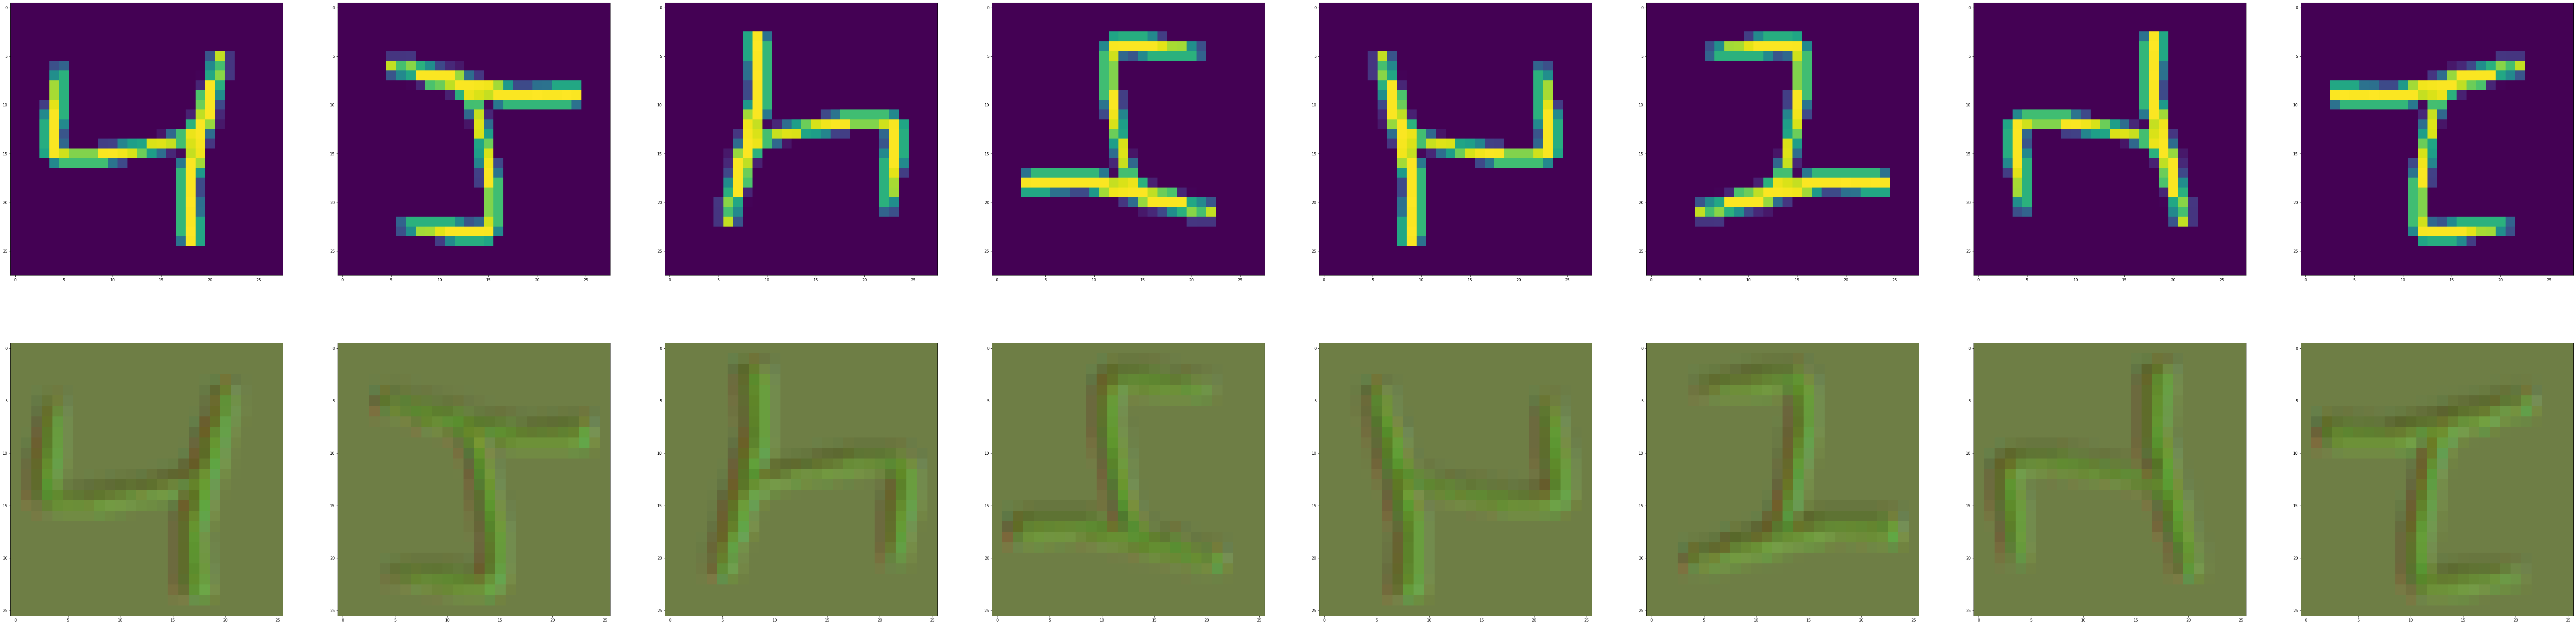

In [31]:
transformed_images = P4M_action(test_image[0], height_axis=0, width_axis=1)
lifted_images = lifting_conv(transformed_images)

fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
gi = 3 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(np.reshape(transformed_images[i], transformed_images[i].shape[:-1]))
  axes[1, i].imshow(lifted_images[i][:, :, gi])

#### On a group convolution

Now we can use the previous layer to lift the image to a signal on the group, and test the equivariance of the group convolution layer on that.

In [32]:
lifted_image = lifting_conv(test_image)

group_conv(lifted_image)


# add a random bias to make sure that also preserves equivariance
group_conv.bias = group_conv.bias + tf.random.normal(shape=group_conv.bias.shape)


for i in range(8):
  layer_g_input, g_layer_input, diff, maxdiff = test_equiv(lifted_image, group_conv, g_index=i, group_valued=True, verbose=False)
  print(f'{i}: {maxdiff}')

0: 0.0
1: 1.1920928955078125e-07
2: 1.1920928955078125e-07
3: 1.1920928955078125e-07
4: 1.1920928955078125e-07
5: 1.1920928955078125e-07
6: 1.1920928955078125e-07
7: 1.1920928955078125e-07


Again this is practically equivariant!

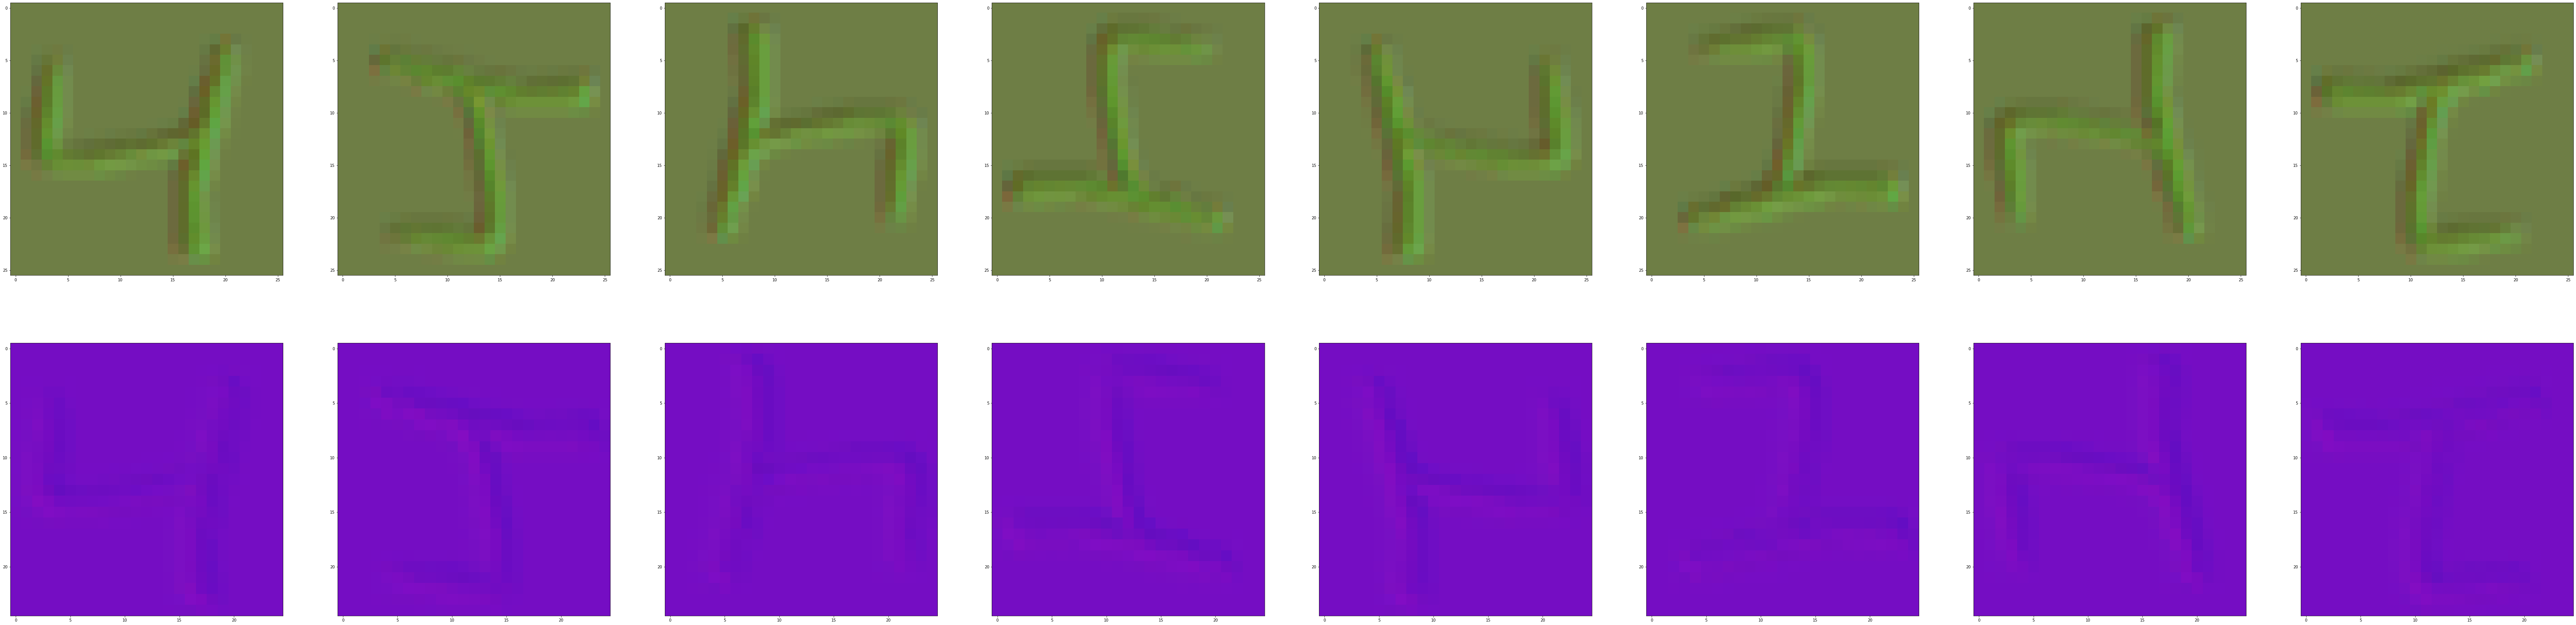

In [33]:
bla = group_conv(lifted_images)

fig, axes = plt.subplots(2, 8)
fig.set_figheight(2 * 15)
fig.set_figwidth(8 * 15)
gi = 3 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(lifted_images[i][:, :, gi])
  axes[1, i].imshow(bla[i][:, :, gi])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(1.1920929e-07, shape=(), dtype=float32)


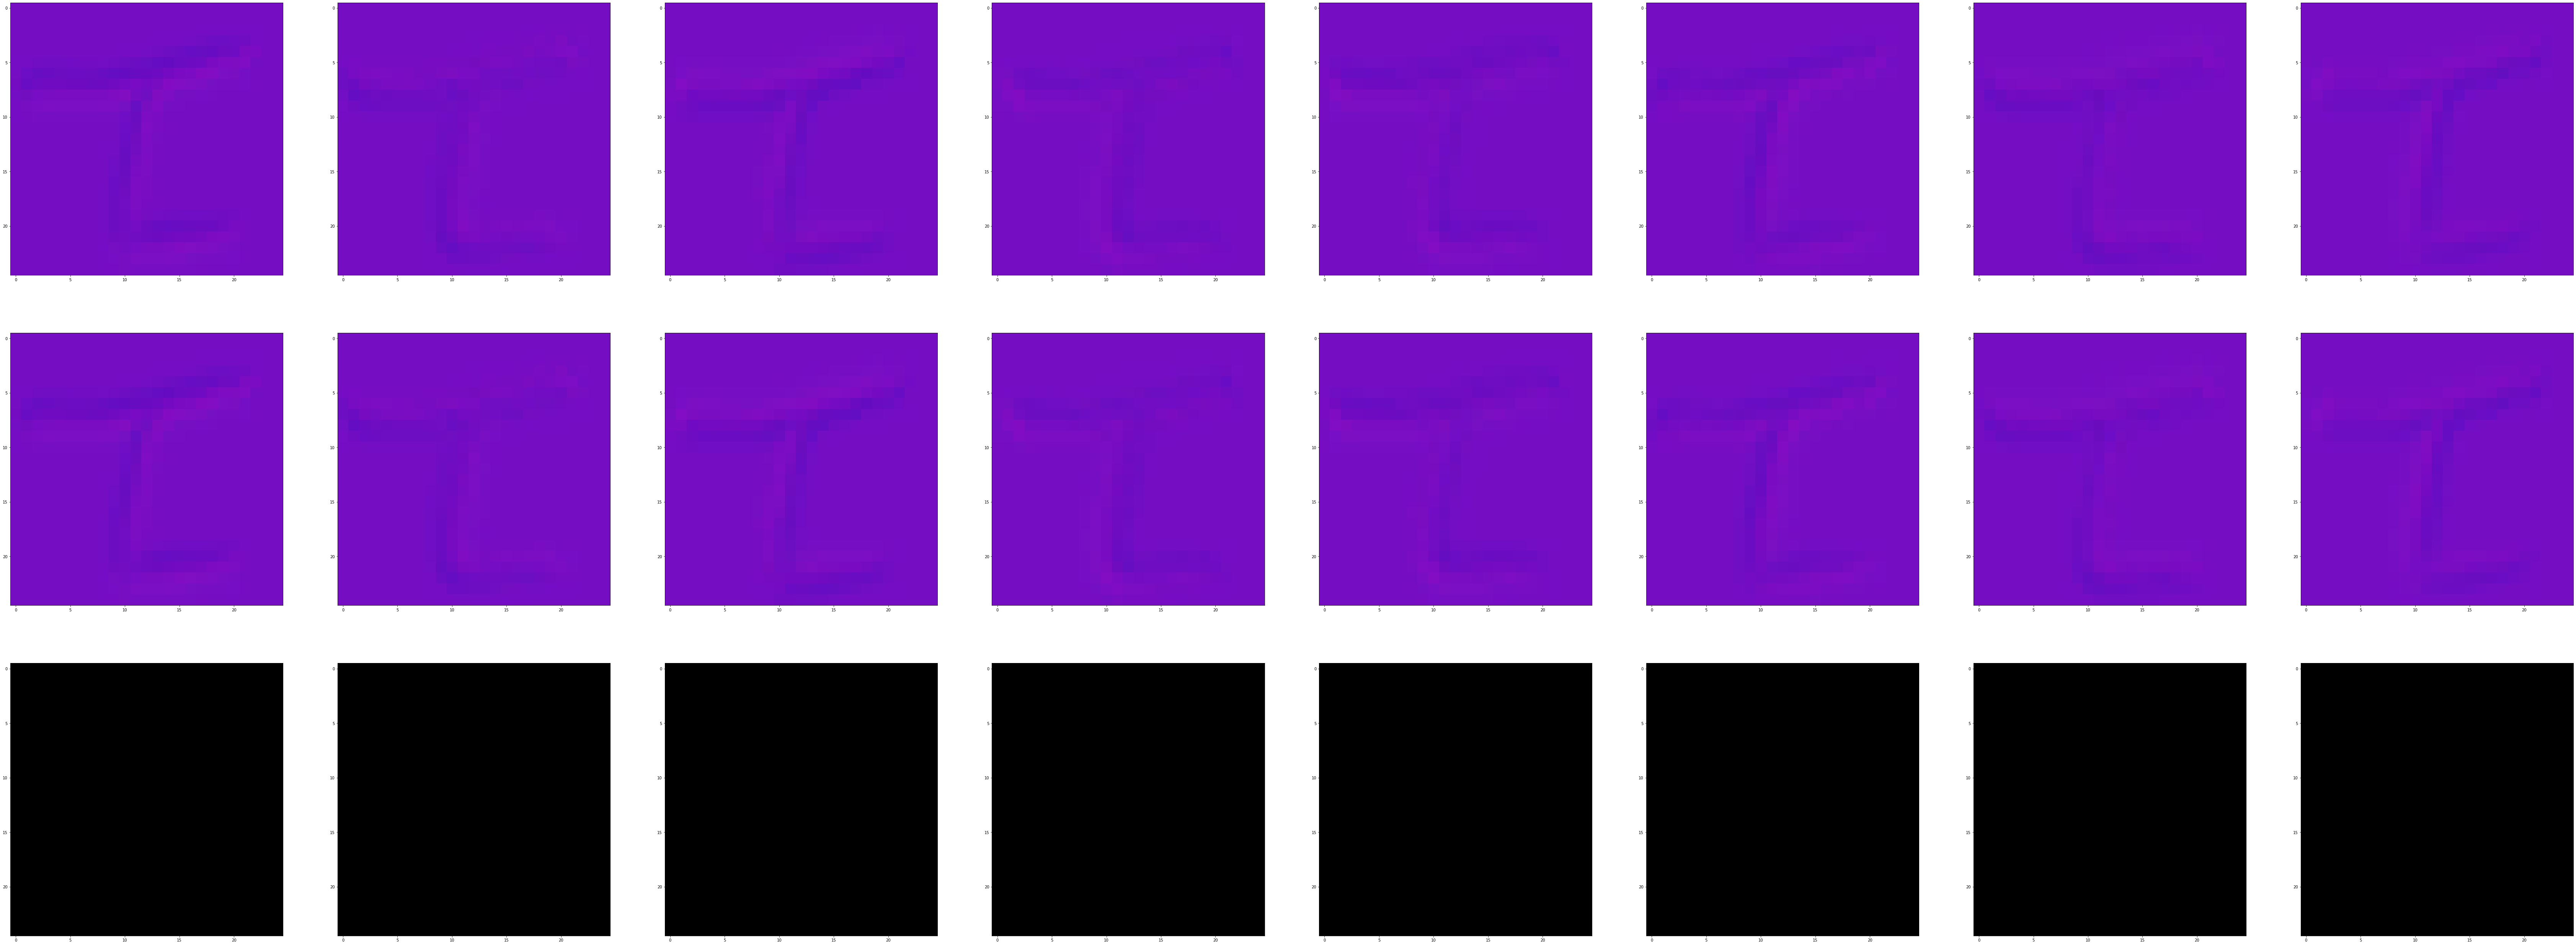

In [34]:
tsta = tf.transpose(layer_g_input, (0, 3, 1, 2, 4))[0]
tstb = tf.transpose(g_layer_input, (0, 3, 1, 2, 4))[0]

fig, axes = plt.subplots(3, 8)
fig.set_figheight(3 * 15)
fig.set_figwidth(8 * 15)
gi = 2 # to visualize the output, just arbitrarily pick one group element 
for i in range(8):
  axes[0, i].imshow(tsta[i])
  axes[1, i].imshow(tstb[i])
  axes[2, i].imshow((tsta - tstb)[i])
print(tf.reduce_max(tf.abs(tsta - tstb)))

## Strides

The next equivariant layer that we will need to construct convolutional networks is the pooling layer. Before discussing this however, we should take a closer look at strides. These are needed for pooling but also a possible ingredient in a convolutional layer, and if you're not careful they can spoil equivariance.

Let's again start with rephrasing regular strides in the language of group theory.
For concreteness let's consider a stride of 2. 
This will compute the values of the new layer only for every other point (along both directions). Seen as a grid, this takes a subgrid: the points $H = \{(2i, 2j) | (i, j) \in \Omega\}$. 
But seeing the points on the grid again as elements in the translation group, this is a subgroup $H \subset G$:
- $e \in H$ ($e = (0, 0) = (2 * 0, 2 * 0)$)
- $g \odot h \in H$ for $g, h \in H$ ($(2i,2j) + (2k,2l) = (2(i+k), 2(j+l)$)
- $h^{-1} \in H$ for $h \in H$ ($(2i,2j) + (2(-i), 2(-j)) = (0, 0) = e$)

We can formalize a pure stride subsampling as a map

$S^G_H: \mathcal{X}(G, \mathcal{C}) \rightarrow \mathcal{X}(H, \mathcal{C})$, 

with 

$S^G_H[y](h) = y(h)$ for $h \in H$, 

and undefined otherwise. This is not $G$-equivariant: $S^G_H[y]$ is only defined on the subgroup, so acting with a $g\in G$ outside of the subgroup can make the result undefined on that input (for example if $h$ is the identity).
It is however still invariant on the subgroup $H$, and trivially so as long as we indeed subsample on a subgroup, because on the subgroup the subsampling map is just the identity.

If we take a different stride $(s,t)$ in both directions, the most general subgroup for regular convolutions would be $H_{s,t} = \{(s i, t j) | (i,j) \in \Omega\}$, the proof above goes through unchanged.

### Group subsampling

Let's now reintroduce the point group. The construction above generalizes immediately, we just have to figure out what the subgroups are.

In particular, if the point group leaves a subgroup of the translations invariant, then the full point group and the subgroup of translations together form a subgroup of the full wallpaper group.

In the point group we had flips, which change the sign of a coordinate, and rotations, which can also change the order of the coordinates. It is easily seen that $H_{s,t}$ is invariant to flips, but not in general to rotations, as if $s$ and $t$ are different, multiples of one won't always turn into mutliples of the other.

But $H_{s,s}$ on the other hand is invariant under all of $D_4$, so this is a subgroup we can subsample on.
This subsampling is technically only equivariant under this subgroup, but since that includes the full point group and both translations on the subsampled grid, it is as good as being fully equivariant.

We are not limited to subgroups of this form though, we could just as well sample on a proper subgroup of the point group as well. 
For instance we could subsample on the group of horizontal and vertical reflections, in which case we can also use different strides.




### Implementation pitfalls

For a subsampling that is purely on the grid and maintains the full point group, in principle we don't have to implement anything. We do have to be very careful in how we use the existing implementation in Keras. Not only to take the same stride in both directions, but also in the nitty gritty details of how the stride is done.

The key concern is that the origin of the output coincides with the origin of the input. 

As an example, consider a 1D input of length 8, and average poooling with pool_size 2 and stride 4:

In [35]:
input_line = tf.range(8, dtype=tf.float32)
print(input_line)
pool_layer = keras.layers.AveragePooling1D(pool_size=2, strides=4)
output_line = pool_layer(tf.reshape(input_line, (1,) + input_line.shape + (1)))[0, :, 0]
print(output_line)

tf.Tensor([0. 1. 2. 3. 4. 5. 6. 7.], shape=(8,), dtype=float32)
tf.Tensor([0.5 4.5], shape=(2,), dtype=float32)


This has sampled two regions: with index 0 and 1, and with index 4 and 5. 
So now the center of the output corresponds to the middle of index 2 and 3 in the input, while the center of the input is in the middle of index 3 and 4. It is now easy to visualize that if we do a reflection, this won't be equivariant.

So what we need for equivariance is that the origins coincide.
In Keras's implementation, the first pooling region is always started at index 0. So if we adopt that convention, what we require is that the last pooling region ends at the last index.

The ends of the pooling regions can be written as:

$\text{end} = n \times \text{stride} + \text{pool_size}$

To make this coincide with the last index in the image, what we need is:

$(\text{image_size} - \text{pool_size} ) \,\%\, \text{stride} == 0$

and indeed, when this is satisfied, the resulting convolutional layer is equivariant. With 'same' padding, Keras will try to pad evenly on both sides. When the parities match it succeeds and the result is equivariant, when they don't it will pad one side with one more pixel than the other, breaking equivariance. So with same padding the layer is equivariant if and only if the padding it has to do is even, which is when the pool size is even

### With 'same' padding

The above is only true without padding (i.e. 'valid' padding).

With 'same' padding it is a little more involved. 
The amount of padding it does can be computed as:

In [36]:
#pad = max(pool_size - stride + (-in_shape % stride), 0)

The previous criterion must still hold, but now for the padded input.
So one condition is:

In [37]:
#same_padding_condition_1 = (in_shape + pad - pool_size) % stride == 0

Furthermore the padding must be done equally on both sides, which is the case when it is even, giving the second condition:

In [38]:
#same_padding_condition_2 = pad % 2 == 0

To be sure we can verify this by checking many random combinations:

In [39]:
def test_equiv_pool(input, layer, g_index, group_valued=True, verbose=True):
  g_input = P4M_action(input, height_axis=1, width_axis=2, new_group_axis=0)[g_index]
  
  layer_input = layer(input)
  layer_g_input = layer(g_input)
  g_layer_input = P4M_action(layer_input, height_axis=1, width_axis=2, new_group_axis=0)[g_index]

  diff = layer_g_input - g_layer_input
  maxdiff = tf.reduce_max(tf.abs(diff))

  return maxdiff

In [40]:
from keras.layers import AveragePooling2D

def test_correlation(image, in_shape, pool_size, stride, padding='valid'):
  image = tf.reshape(image, (1,) + image.shape)
  resized_image =  tf.image.resize_with_pad(image, in_shape, in_shape)

  pool_layer = AveragePooling2D(pool_size=pool_size, strides=stride, padding=padding)

  out = pool_layer(resized_image)

  # test equiv
  maxdiffs = tf.concat([test_equiv_pool(resized_image, pool_layer, g_index=i, group_valued=False, verbose=False) for i in range(8)], axis=0)
  maxdiff = tf.reduce_max(maxdiffs).numpy()

  is_equiv = maxdiff < 1e-6

  if padding == 'same':
    pad = max(pool_size - stride + (-in_shape % stride), 0)
    hypothesis = (in_shape + pad - pool_size) % stride == 0 and pad % 2 == 0
  else:
    hypothesis = (in_shape - pool_size) % stride == 0

  # if the output has only one point, it's trivially equivariant
  hypothesis = hypothesis or out.shape[1] <= 1

  if not hypothesis == is_equiv:
    print('FALSE!!', is_equiv, hypothesis, padding)
  return is_equiv == hypothesis

hypothesis = True
i = 0
while hypothesis and i < 2_000:
  in_shape = np.random.randint(low=50, high=70)
  pool_size = np.random.randint(low=1, high=min(10, in_shape))
  stride = np.random.randint(low=1, high=5)
  padding = np.random.choice(['same', 'valid'])
  hypothesis = test_correlation(image, in_shape=in_shape, pool_size=pool_size, stride=stride, padding=padding)
  i += 1
print(i, in_shape, pool_size, stride)

2000 63 2 1


### Practical implementation

Here there is a design choice to be made, on how much we restrict using parameter combinations that spoil equivariance.

We'll add two padding options, for a total four:
- `valid_equiv`, 
- `same_equiv`, 
- `valid`: 
- `same`: 

We'll make `valid_equiv` the default one, and with the first two options we'll add the minimal amount of padding on top of the non, "`_equiv`" variant that makes it equivariant.

For the last two options, we'll check if it's already equivariant by default, in which case we don't have to do anything.
If it's not, we'll raise an error.
The error should explain what's wrong and how to fix it:
- use one of the equiv options
- change `stride` or `pool_size`

We'll add another option `allow_non_equivariance` to turn off the error, to still make it possible to use the default padding, but with enough safeguards that it's only possible if explicitly asked for.

Note that it is also possible that no padding at all will preserve equivariance, with a given input and kernel size and stride.
This is because the padding should also be even, and we can only add multiples of the stride while preserving the other condition. So this applies only when the stride is even. In this case we'll return another error, again unless `allow_non_equivariance` is True.

We can collect all this functionality in another Keras layer, that subclasses from the base Layer class. This will do any extra padding required for equivariance (so the same padding is still handled by the convolution layer.

We can store this layer in the group-convolution and pooling layers, build it during the GroupConv2D's build, and call it during its call.

As this is now mainly bookkeeping, we won't include the code here, see the actual implementation for any further detais.

## Equivariant layer: Pooling

Pooling is also equivariant, and trivially so given the discussion on strides above. The reason is that a pooling layer can be seen of as two steps: 
1. compute some statistic (max or average usually) on some region $U$ around each point
2. subsample the result

In practice this would waste a lot of computation and so it is not implemented like this, but for the analysis it doesn't matter. 

We have already discussed the subsampling step in the section on strides above, and we've seen that it can be made equivariant provided one is careful with the implementation details.

A simple way to see that the first step is also equivariant is to phrase it as a convolution.

### Pooling without subsampling

Just as convolution, pooling (without stride) is a map from signals on the group to signals on the group, $P^G_U: \mathcal{X}(G, \mathcal{C}) \rightarrow \mathcal{X}(G, \mathcal{C})$, where $U$ is the elementary region over which pooling is done.

For regular (max) pooling, the pooled signal at some point p in the grid will be:

$(P_U y)(p) = \max_{q \in U_p} y(q)$

where $U_p$ is some region around $p$, let's say a square of size 3 centered at $p$. We can rewrite $U_p = p + U$, where $U$ now is the square of size 3 centered at the origin. Now interpreting both $p$ itself and the points in $U$ as elements of the translation group rather than points on the grid, we can again rewrite: $R_p = p \odot U$. So we can write the above as 

$(P y)(p) = \max_{u \in U} y(p \odot u)$

Written in this way it generalizes directly to group-pooling.

Going back to the analogy with convolutions, $U$ can be thought of as the region where the pooling kernel is nonzero.
To see the analogy explicitly, take $\psi$ to be a signal on the group, which vanishes everywhere but on some subset of group elements $U$, where it takes the value $1 / |U|$ (with $|U|$ the number of elements in $U$). Let $y$ be a signal on the group that we want to pool over. For simplicity take the domains of both signals to be just $\mathbb{R}$.
Then the convolution with kernel $\psi$ is:


$C_\psi^G(y)(g) \equiv (\psi \star y)(g) = \sum_{h \in G} \langle(g \otimes \psi)(h), y(h)\rangle_\mathbb{R} = \sum_{h \in G} \psi(g^{-1} \odot h) y(h)$ 

$ = \sum_{h \in G} \psi(h) y(g \odot h) = \frac{1}{|U|} \sum_{h\in U} y(g \odot h)$

which is exactly average pooling. Setting the kernel to 1 on $U$ instead and replacing the sum with a maximum gives max pooling.

So pooling is equivariant because group-convolution is (and replacing the sum with a max for max pooling doesn't affect the argument).

Seeing pooling as a convolution with some fixed kernel also makes it clear that the pooling region $U$ is completely arbitrary, it doesn't have to respect the group structure in any way.

### Pooling with subsampling

For completeness, the general group-pooling layer takes the form $P^G_{H, U} : \mathcal{X}(G, \mathcal{C}) \rightarrow \mathcal{X}(H, \mathcal{C})$, where $G$ is the original group, $H \subset G$ is the subgroup we subsample on, and $U$ is the region we compute the statistic on. 

The subgroup $H$ can be the full point group, but a subgroup of the translations, or a subgroup of the point group but all translations, or subgroups of both, as long as it is a subgroup of the full wallpaper group.

While any region $U$ is allowed, there is certainly a natural choice. On a grid without additional symmetries, the natural choice is to set the stride equal to the kernel size, which amounts to tiling the grid into non-overlapping subregions $U$, such that each point in the original grid contributes to exactly one point in the subsampled grid.

The generalized version of this is that $H \odot U = G$, that is, if we take the subset $U$ ($U$ itself is not necessarily a subgroup!), i.e. a 3 by 3 square centered at the origin in the regular case, and transform it by all elements of the subgroup, we get back the full group.

The group theoretic concept for such a region $U$ that satisfies this is a coset, that is, each point in $U$ corresponds to a coset of the subgroup $H \subset G$, and so $U$ is the set of all cosets. A coset of $H$ is the set consisting of compositions of the whole subgroup with a single element of $G$, $g H = \{g h | h \in H\}$. $g$ is called a coset representative, and any other $g'$ that is related to $g$ by a composition with an element of $H$ gives the same coset.

In the case of a grid without extra symmetries, the natural coset representatives would be the points in the 3 by 3 square around the origin. If we do have extra symmetries but we don't subsample on the point group, then any element of the point group can serve as a representative (in particular the identity).

If we do subsample also on the point group, for example on only the rotations, without flips, then natural representatives are the horizontal flip and the identity.


### practical implementation (TODO)

Conceptually, given the interpretation of pooling as a convolution with a particular filter, we need to give the pooling layer exactly the same makeover as we did the convolution layer. The implementation is of course different though, so the details will be different.


In addition to implement the most general pooling we need to implement pooling over subgroups of the point group.
This is simple, it can be done before or after the spatial pooling, and requires only knowing which group elements in $G$ correspond to which subgroup in $H$. It does not make sense to implement this before we implement the subgroups themselves though.

So for the moment, we can make do with a built in 3D pooling layer, and just not pool on the group axis, and manually make sure we use compatible strides and pool sizes.

## Invariant layer: global pooling

The invariant layer is a global pooling layer, where now we pool over the full group, both the translational and the other part.

We could again subclass the regular layer, in this case `GlobalPooling2D`, and add the pooling over the group. But we can just as well directly use the `GlobalPooling3D` layer.

# Testing on MNIST

We can now use these layers and test a full network on MNIST.

Below is a helper function that will allow us to construct a convolutional network, or a similar group-convolutional network.

The pooling sizes have been chosen carefully to maintain equivariance.

In [41]:
from tensorflow import keras
import tensorflow as tf

In [42]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, Dense, Dropout, Input, Flatten, GlobalMaxPooling2D, GlobalMaxPooling3D
from tensorflow.keras.models import Model

def create_pooling_layer(my_conv=Conv2D, pool_size=2):
  if my_conv is Conv2D:
    return MaxPooling2D(pool_size=pool_size, strides=2)
  else:
    return MaxPooling3D(pool_size=(pool_size, pool_size, 1), strides=(2, 2, 1), padding='valid')

def construct_model(my_conv=Conv2D, filter_sizes=[32, 64, 128], bias=True):
  input_shape = (28, 28, 1)
  if my_conv is Conv2D:
    invariant = GlobalMaxPooling2D()
  else:
    invariant = GlobalMaxPooling3D() 
  inputs = Input(shape=input_shape)
  x = inputs

  x = my_conv(filters=filter_sizes[0], kernel_size=3, strides=1, activation='relu', padding='valid', use_bias=bias)(x)
  x = create_pooling_layer(my_conv, pool_size=2)(x)

  x = my_conv(filters=filter_sizes[1], kernel_size=3, strides=1, activation='relu', padding='valid', use_bias=bias)(x)
  x = create_pooling_layer(my_conv, pool_size=3)(x)

  x = my_conv(filters=filter_sizes[2], kernel_size=3, activation='relu', padding='valid', use_bias=bias)(x)
  x = invariant(x)
  #x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)
  outputs = x

  model = Model(inputs=inputs, outputs=outputs) 
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
  model.summary()
  return model

We can create both models with a similar amount of parameters and see which performs better.

## Regular CNN

In [43]:
regular_cnn = construct_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0     

In [44]:
batch_size = 128
epochs = 15
regular_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 5s 11ms/step - loss: 0.3109 - acc: 0.9088 - val_loss: 0.0709 - val_acc: 0.9793
Epoch 2/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0665 - acc: 0.9792 - val_loss: 0.0460 - val_acc: 0.9858
Epoch 3/15
422/422 [==============================] - 4s 10ms/step - loss: 0.0461 - acc: 0.9856 - val_loss: 0.0383 - val_acc: 0.9895
Epoch 4/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0361 - acc: 0.9885 - val_loss: 0.0312 - val_acc: 0.9917
Epoch 5/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0283 - acc: 0.9911 - val_loss: 0.0385 - val_acc: 0.9883
Epoch 6/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0231 - acc: 0.9923 - val_loss: 0.0419 - val_acc: 0.9882
Epoch 7/15
422/422 [==============================] - 4s 9ms/step - loss: 0.0211 - acc: 0.9931 - val_loss: 0.0332 - val_acc: 0.9910
Epoch 8/15
422/422 [==============================] - 4s 9ms/step - loss:

In [45]:
regular_cnn.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 0s 6ms/step - loss: 0.0309 - acc: 0.9918


[0.03092433139681816, 0.9918000102043152]

## Group-CNN

In [46]:
group_cnn = construct_model(my_conv=P4M_Conv2D, filter_sizes=[32, 16, 64])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
group_conv2d_2 (GroupConv2D) (None, 26, 26, 8, 32)     320       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 13, 13, 8, 32)     0         
_________________________________________________________________
group_conv2d_3 (GroupConv2D) (None, 11, 11, 8, 16)     36880     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 5, 8, 16)       0         
_________________________________________________________________
group_conv2d_4 (GroupConv2D) (None, 3, 3, 8, 64)       73792     
_________________________________________________________________
global_max_pooling3d (Global (None, 64)                0   

In [47]:
batch_size = 128
epochs = 15
group_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 22s 48ms/step - loss: 0.4510 - acc: 0.8558 - val_loss: 0.1328 - val_acc: 0.9568
Epoch 2/15
422/422 [==============================] - 19s 46ms/step - loss: 0.1630 - acc: 0.9486 - val_loss: 0.1401 - val_acc: 0.9552
Epoch 3/15
422/422 [==============================] - 19s 46ms/step - loss: 0.1195 - acc: 0.9616 - val_loss: 0.1333 - val_acc: 0.9523
Epoch 4/15
422/422 [==============================] - 19s 46ms/step - loss: 0.0953 - acc: 0.9688 - val_loss: 0.1115 - val_acc: 0.9618
Epoch 5/15
422/422 [==============================] - 19s 46ms/step - loss: 0.0774 - acc: 0.9744 - val_loss: 0.0830 - val_acc: 0.9725
Epoch 6/15
422/422 [==============================] - 19s 46ms/step - loss: 0.0680 - acc: 0.9778 - val_loss: 0.0836 - val_acc: 0.9762
Epoch 7/15
422/422 [==============================] - 20s 46ms/step - loss: 0.0580 - acc: 0.9806 - val_loss: 0.0746 - val_acc: 0.9753
Epoch 8/15
422/422 [==============================] - 19s 46ms

In [48]:
group_cnn.evaluate(x_test, y_test, batch_size=batch_size)

79/79 [==============================] - 2s 21ms/step - loss: 0.2014 - acc: 0.9556


[0.20136334002017975, 0.9556000232696533]

Somewhat surprisingly, the p4m invariant network performs almost as good as the regular CNN, despite the fact that the MNIST data clearly is not invariant under p4m. In particular the digits 6 and 9 even transform into one another under a 180 degree rotation.

Still, the misclassification rate is about 4% vs 1% for the regular network, a significant difference. A better match for this model would be natural images, such as CIFAR, on which it achieved state of the art results at the time of publication of the original paper.

### Invariance check

In [49]:
predictions = group_cnn(transformed_images) 
print("Predicted classes: ", tf.argmax(predictions, axis=1).numpy())
print("Maximal absolute difference in probabilities: ", tf.reduce_max(tf.abs(predictions - predictions[0])).numpy())
print("Mean absolute difference in probabilities: ", tf.reduce_mean(tf.abs(predictions - predictions[0])).numpy())

Predicted classes:  [4 4 4 4 4 4 4 4]
Maximal absolute difference in probabilities:  1.0477379e-08
Mean absolute difference in probabilities:  5.571597e-10


The network is indeed invariant to very good accuracy!

As a sanity check we can compare this to the regular CNN:

In [50]:
predictions = regular_cnn(transformed_images) 
print("Predicted classes: ", tf.argmax(predictions, axis=1).numpy())
print("Maximal absolute difference in probabilities: ", tf.reduce_max(tf.abs(predictions - predictions[0])).numpy())
print("Mean absolute difference in probabilities: ", tf.reduce_mean(tf.abs(predictions - predictions[0])).numpy())

Predicted classes:  [4 5 4 5 4 2 4 8]
Maximal absolute difference in probabilities:  0.99987614
Mean absolute difference in probabilities:  0.10600753


As expected the regular convolution is not invariant. 

When including any kind of downsampling though, either through a pooling layer or with strided convolutions, invariance is spoiled.